In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xplique keras_cv
!cp "/content/drive/MyDrive/Harmonizer zoo/data/cka_imagenet_val.npy" ./
!cp -r "/content/drive/MyDrive/Saliency Strike Back/data/resnet50_explanations" ./

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 16.4 MB/s eta 0:00:00


In [ ]:
import xplique
from xplique.attributions import *
import tensorflow as tf
import numpy as np
import keras_cv
from keras_cv.models import *

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

Using TensorFlow backend


<ipython-input-2-f6199f6b849b>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

102869336/102869336 [==============================] - 1s 0us/step


In [ ]:
X = np.load('cka_imagenet_val.npy')
X = preprocess(X)
Y = tf.one_hot(np.argmax(model.predict(X, 256), -1), 1_000)
X.shape, Y.shape

20/20 [==============================] - 18s 517ms/step


((5000, 224, 224, 3), TensorShape([5000, 1000]))

In [ ]:
X.shape, Y.shape

((5000, 224, 224, 3), TensorShape([5000, 1000]))

# Generate and save explanations

In [ ]:
resnet = tf.keras.applications.ResNet50V2(classifier_activation='linear')
#model = lambda x : tf.nn.sigmoid(resnet(x))
model = resnet

In [ ]:
from xplique.attributions import *
from xplique.metrics import *

In [ ]:
baselines = {
    'zero': lambda x : tf.zeros(x.shape).numpy(),
    'uniform': lambda x : np.random.normal(size=x.shape).astype(np.float32)
}

In [ ]:
np.random.normal()

In [ ]:
import os

l = 300
bs = 128
steps = 10

RESULTS = []
for baseline_text, baseline_func in baselines.items():

  deletion = Deletion(model, X[:l], Y[:l], batch_size=bs, steps=steps, baseline_mode = baseline_func)
  insertion = Insertion(model, X[:l], Y[:l], batch_size=bs, steps=steps, baseline_mode = baseline_func)
  #muf = MuFidelity(model, X[:l], Y[:l], batch_size=bs, nb_samples=128, grid_size=12, baseline_mode = baseline_func)

  p = "resnet50_Saliency.npy"
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  s_del = deletion.detailed_evaluate(np.array(h))
  s_ins = insertion.detailed_evaluate(np.array(h))
  #s_muf = muf(h)

  RESULTS.append((p, s_del, s_ins))
  print('done for', p)


done for resnet50_Saliency.npy
done for resnet50_Saliency.npy


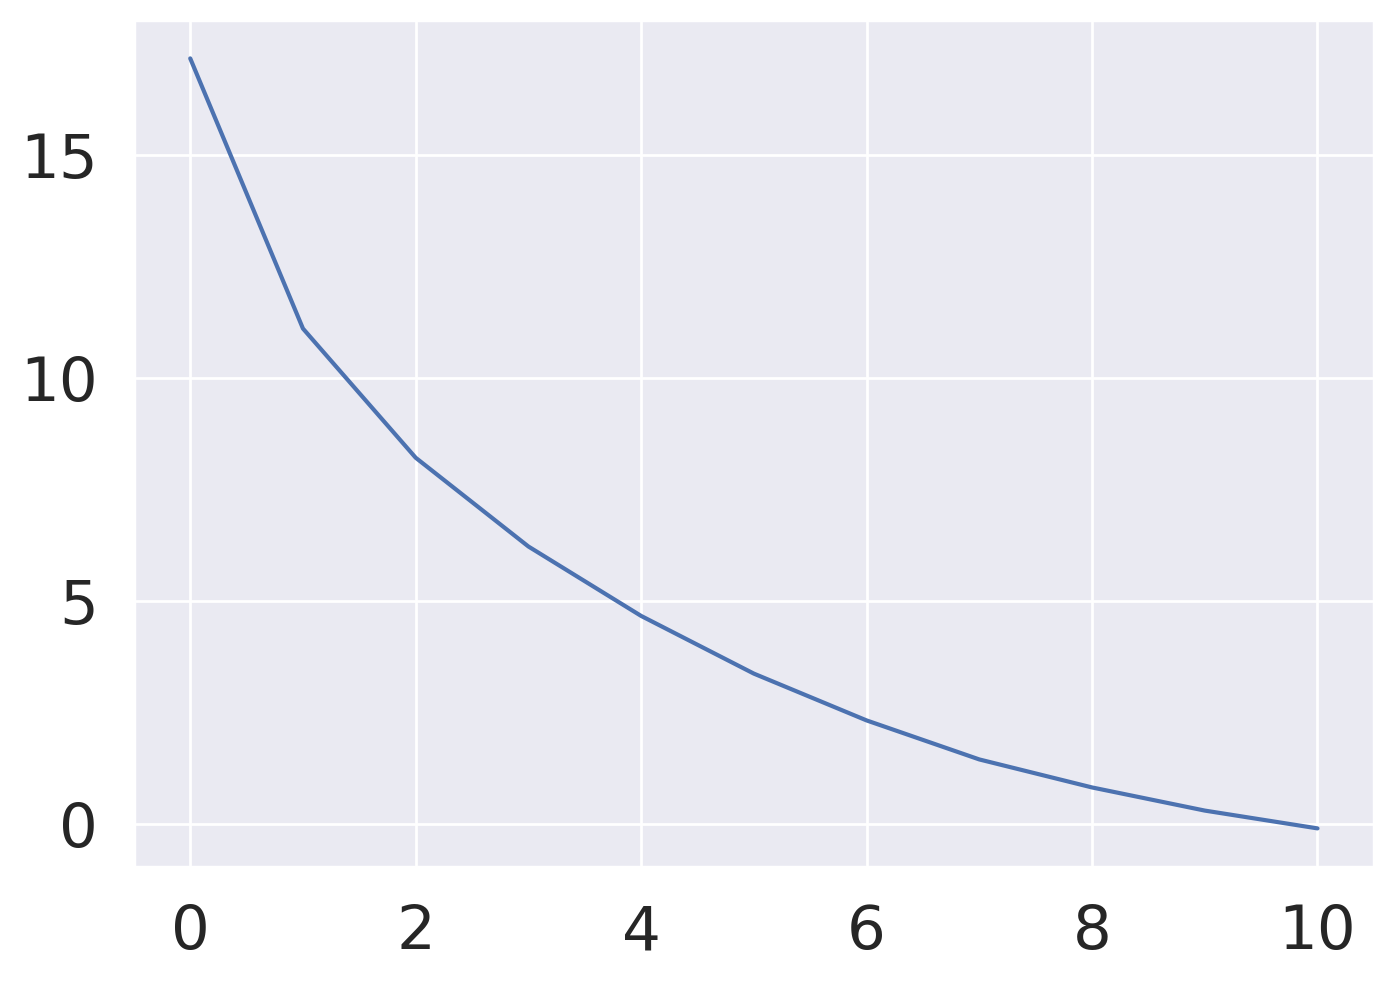

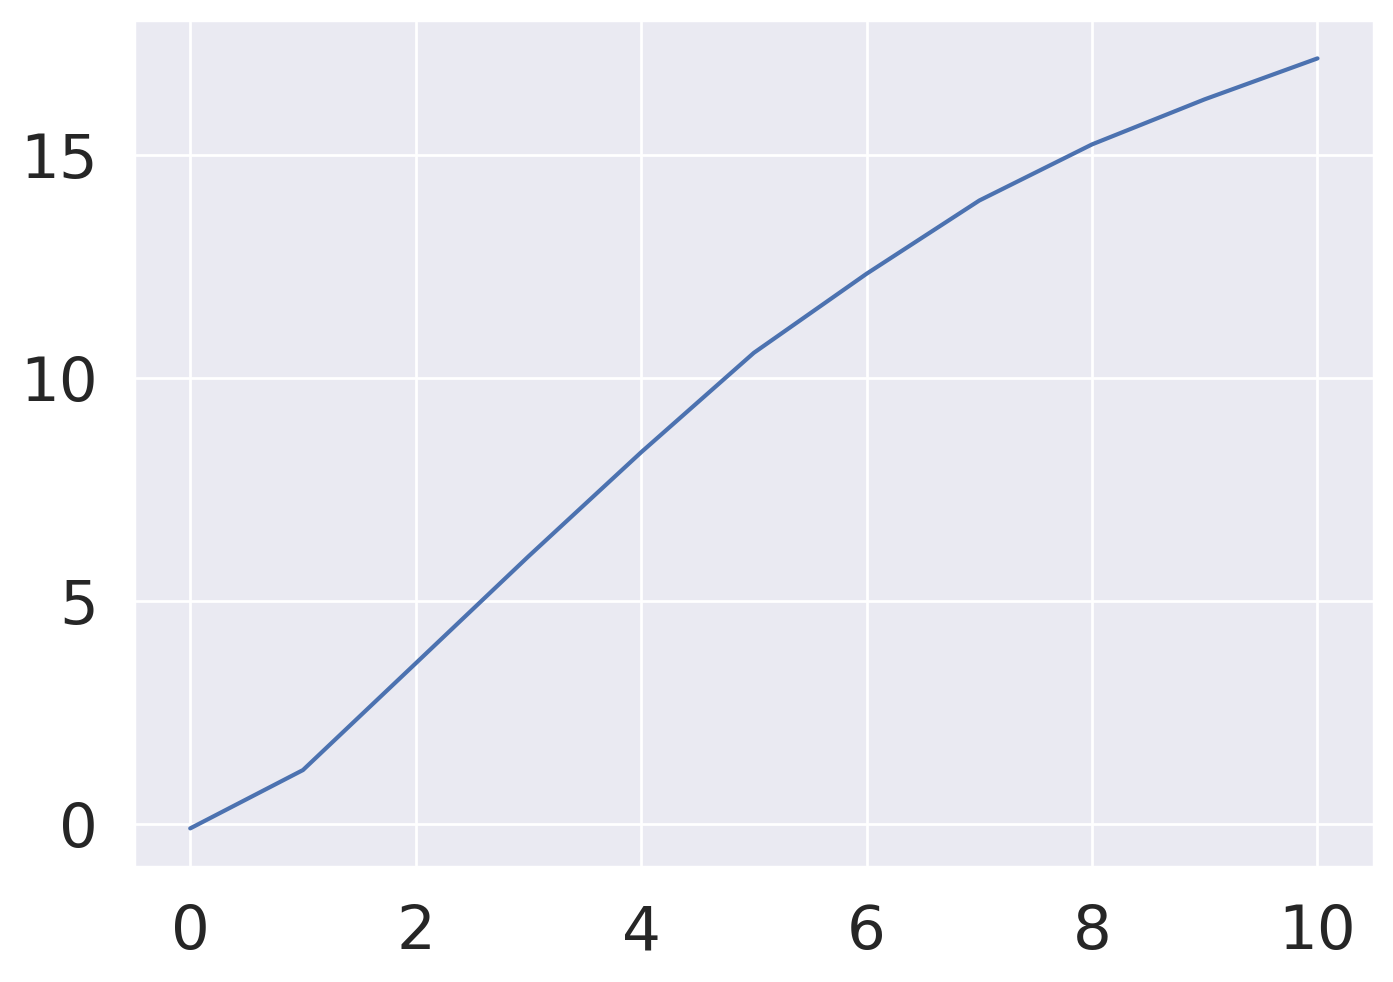

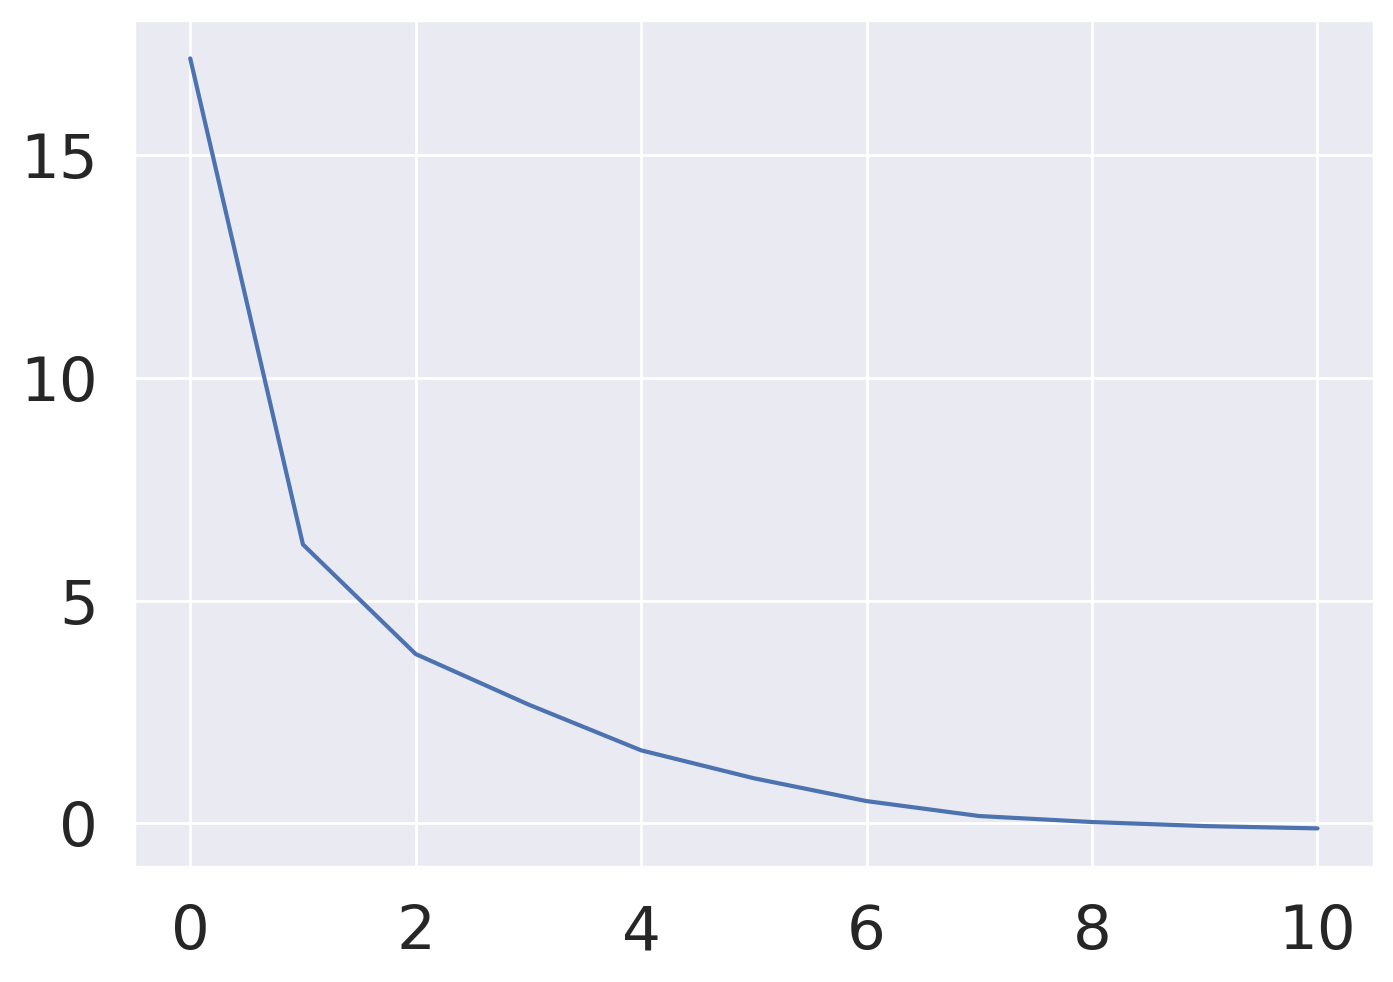

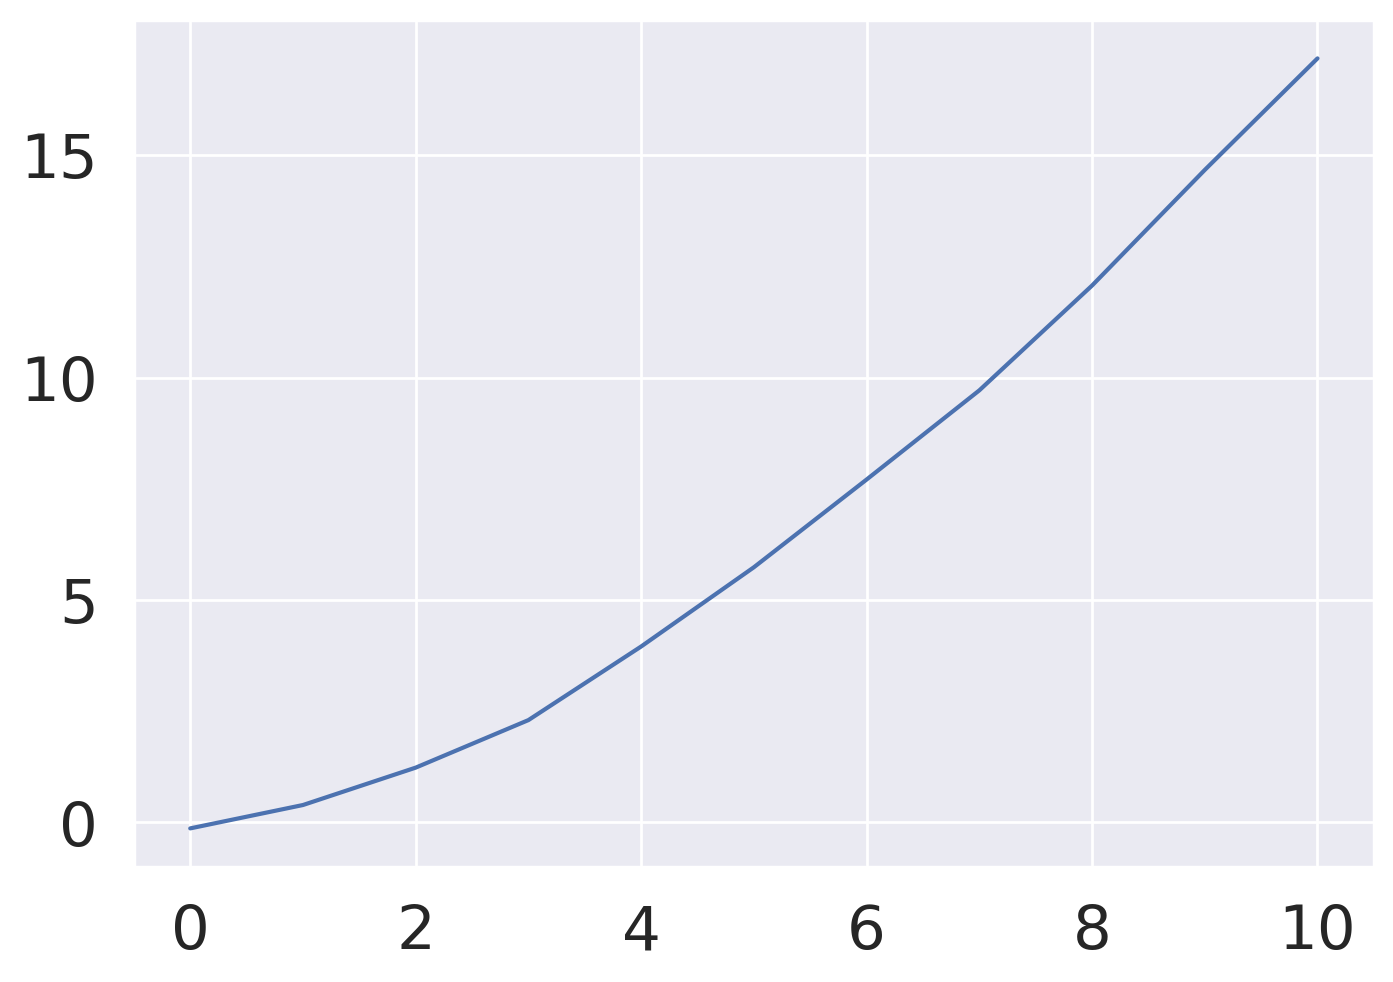

In [ ]:
for i in range(2):
  p, sdel, sins = RESULTS[i]

  d = [sdel[k] for k in sdel.keys()]
  plt.plot(d)
  plt.show()

  d = [sins[k] for k in sins.keys()]
  plt.plot(d)
  plt.show()

0.36363636363636365


<ipython-input-55-edbfe94b7157>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-ticks")


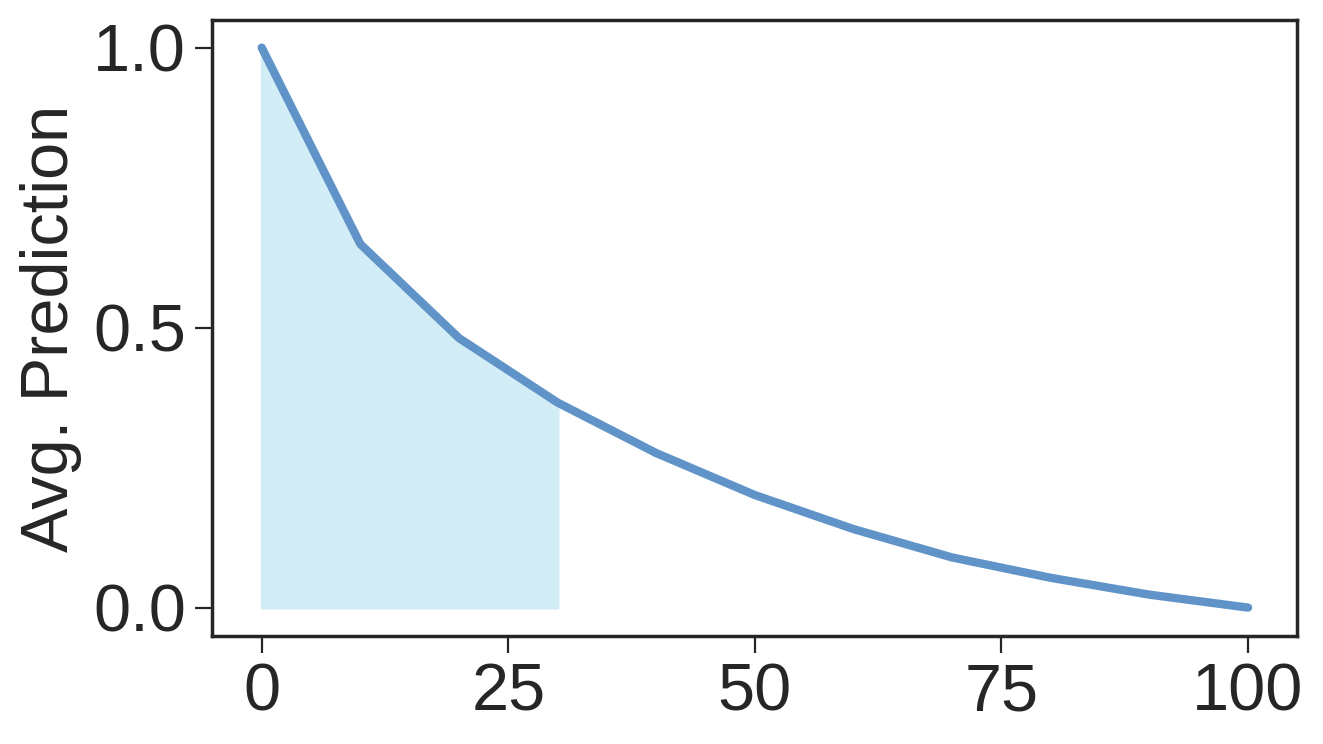

0.8181818181818182


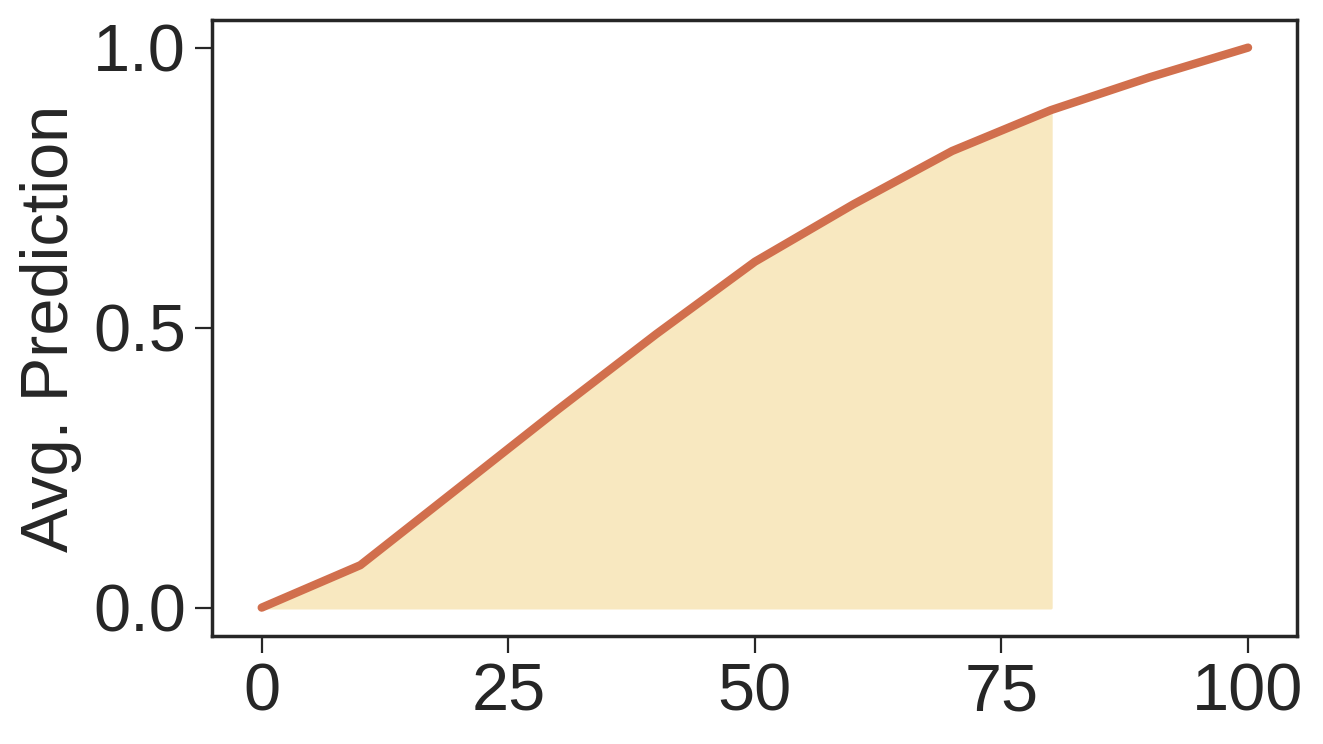

0.18181818181818182


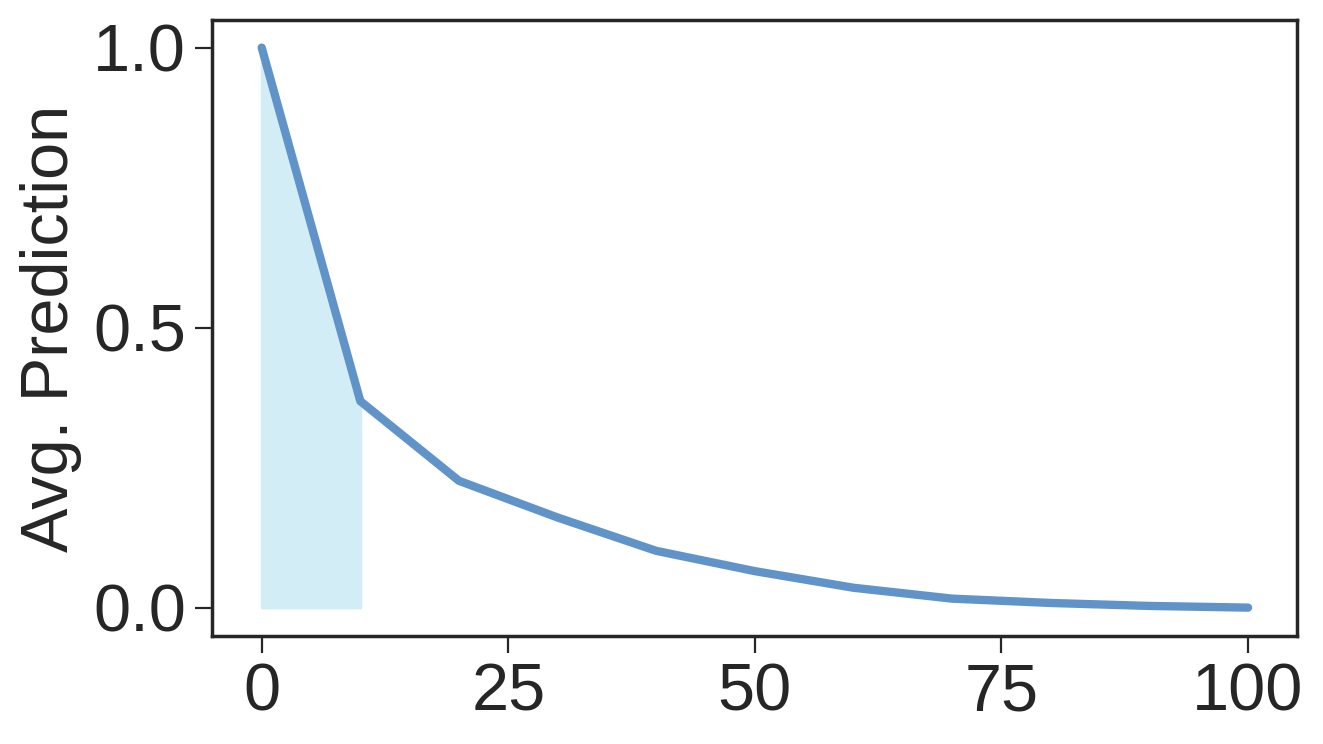

0.9090909090909091


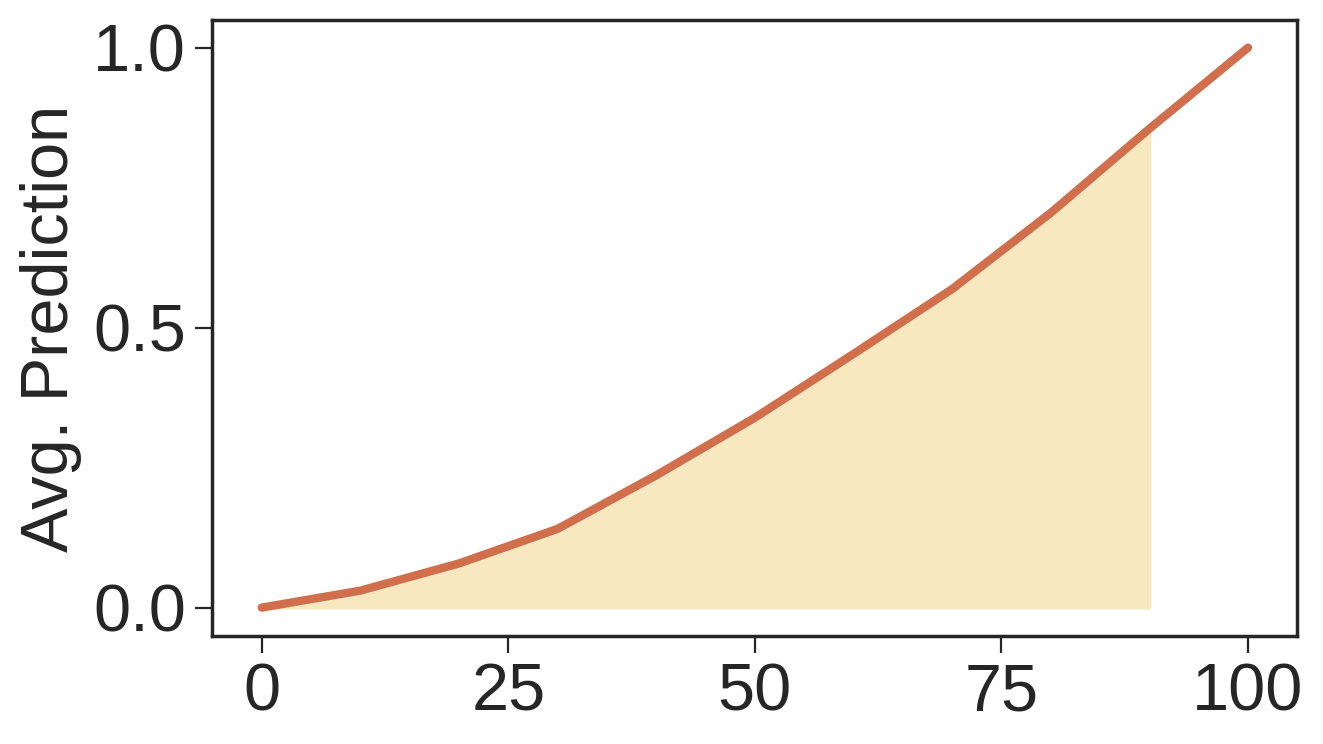

In [ ]:
import scipy
import matplotlib as mpl
from scipy import interpolate
import matplotlib

def set_size(w,h):
  plt.rcParams["figure.figsize"] = [w,h]

def fontsize(mult):
  matplotlib.rcParams.update({'font.size': 12 * mult})

mpl.rcdefaults()
fontsize(2.0)
set_size(7, 4)
plt.style.use("seaborn-ticks")

blue_1 = (96, 148, 200)
blue_2 = (211, 237, 246)
orange_1 = (209, 111, 77)
orange_2 = (248, 232, 192)

def c(color):
  return np.array(color) / 255.0

lw = 3.0

def norm(y):
  y = np.array(y)
  y -= np.min(y)
  y /= np.max(y)
  return y

def auc(y, c, mode='ins', p=0.8):
  total = np.sum(y)
  x_p = None
  for i in range(len(y)):
    s = np.sum(y[:i+1])
    if s >= 0.8 * total and x_p is None:
      x_p = i
  plt.fill_between(np.arange(x_p), y[:x_p]*0.0, y[:x_p], color=c)
  print(float(x_p) / len(y))

for i in range(2):
  p, sdel, sins = RESULTS[i]

  d = [sdel[k] for k in sdel.keys()]
  d = norm(d)
  plt.plot(d, color=c(blue_1), lw=lw)
  auc(d, c(blue_2), 'del')
  plt.xticks(np.linspace(0, len(d)-1, 11//2), np.linspace(0, 100, 11//2).astype(np.int32))
  plt.ylabel('Avg. Prediction')
  plt.show()

  d = [sins[k] for k in sins.keys()]
  d = norm(d)
  plt.plot(d, color=c(orange_1), lw=lw)
  auc(d, c(orange_2), 'ins')
  plt.xticks(np.linspace(0, len(d)-1, 11//2), np.linspace(0, 100, 11//2).astype(np.int32))
  plt.ylabel('Avg. Prediction')
  plt.show()

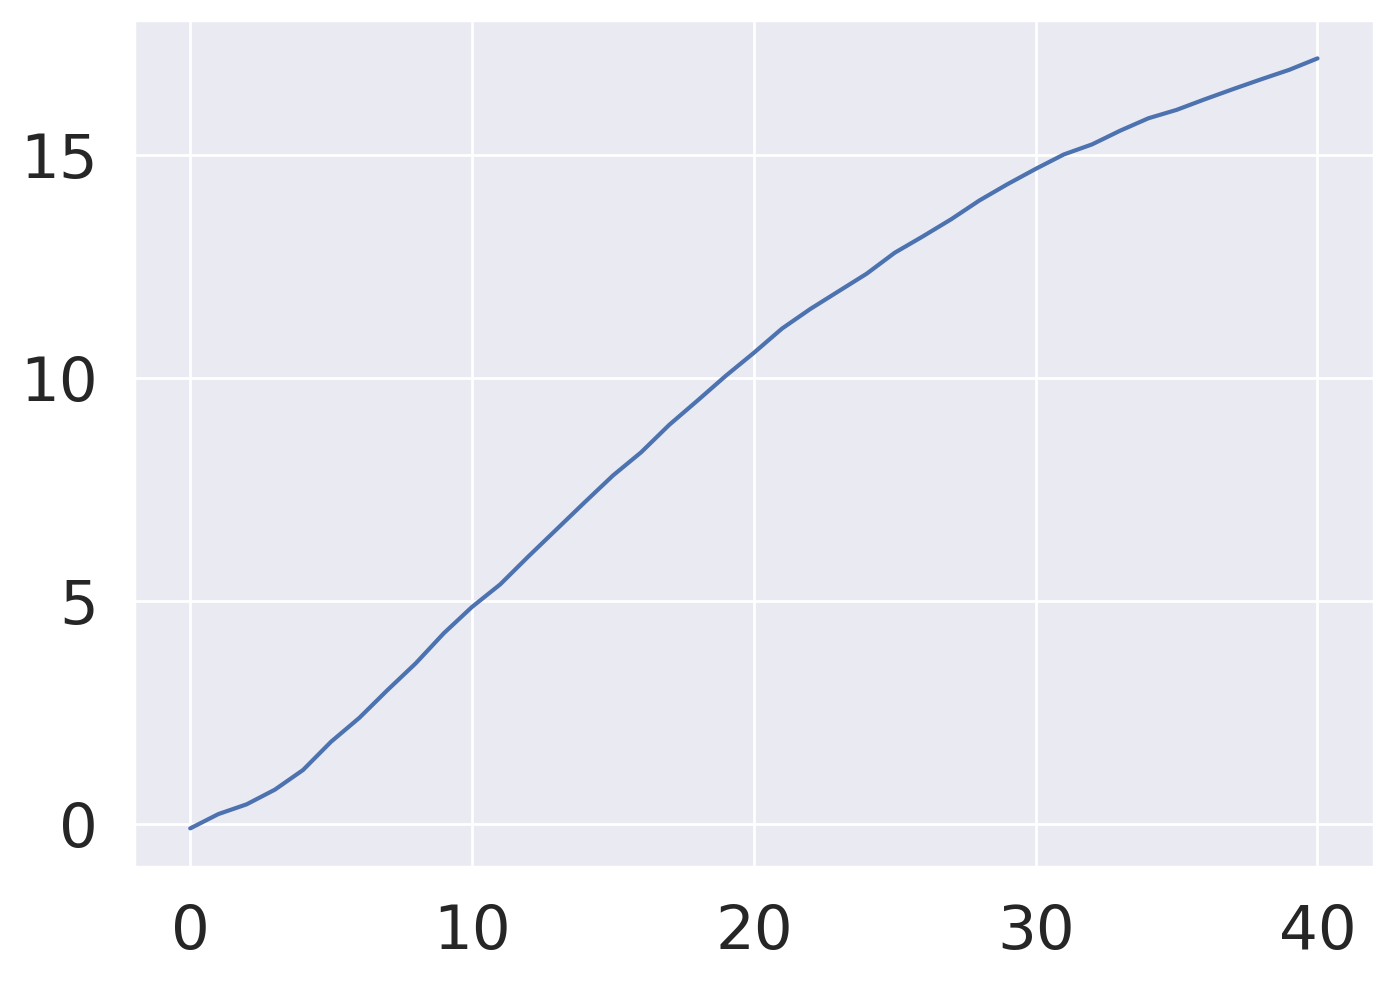

In [ ]:
d = [sins[k] for k in sins.keys()]
#d = [inv_sigmoid(x) for x in d]
#d = norm(d)
plt.plot(d)

In [ ]:
np.save('del_ins_curve.npy', [sdel, sins])

In [ ]:
def sig(x):
  return tf.nn.sigmoid(x)

d = [sins[k] for k in sins.keys()]
#d = [sig(x) for x in d]
#d = [inv_sigmoid(x) for x in d]
#d = norm(d)
plt.plot(d)

In [ ]:
for baseline_text, baseline_func in baselines.items():
  print(baseline_text)

  data = np.load(f'{baseline_text}.npy', allow_pickle=True)[()]

  methods = np.array([m for m, d, i, _ in data])

  best_del = np.argsort([d for m, d, i, _ in data])
  best_ins = np.argsort([i for m, d, i, _ in data])[::-1]

  for mi in best_ins:
    print(methods[mi])

  print('\n\n')


zero
resnet50_Rise.npy
resnet50_GradCAMPP.npy
resnet50_GradCAM.npy
resnet50_HsicAttributionMethod.npy
resnet50_GuidedBackprop.npy
resnet50_SquareGrad.npy
resnet50_VarGrad.npy
resnet50_SobolAttributionMethod.npy
resnet50_SmoothGrad.npy
resnet50_IntegratedGradients.npy
resnet50_GradientInput.npy
resnet50_Saliency.npy
resnet50_DeconvNet.npy
resnet50_Occlusion.npy



uniform
resnet50_Rise.npy
resnet50_GradCAMPP.npy
resnet50_GradCAM.npy
resnet50_HsicAttributionMethod.npy
resnet50_SobolAttributionMethod.npy
resnet50_VarGrad.npy
resnet50_SquareGrad.npy
resnet50_GuidedBackprop.npy
resnet50_IntegratedGradients.npy
resnet50_SmoothGrad.npy
resnet50_GradientInput.npy
resnet50_Saliency.npy
resnet50_Occlusion.npy
resnet50_DeconvNet.npy



normal
resnet50_Rise.npy
resnet50_GradCAMPP.npy
resnet50_GradCAM.npy
resnet50_HsicAttributionMethod.npy
resnet50_SobolAttributionMethod.npy
resnet50_VarGrad.npy
resnet50_SquareGrad.npy
resnet50_GuidedBackprop.npy
resnet50_IntegratedGradients.npy
resnet50_SmoothGrad

In [ ]:
import os

for p in os.listdir('resnet50_explanations'):
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  s_del = deletion(h)
  s_ins = insertion(h)
  s_muf = muf(h)

  print(p, s_del, s_ins, s_muf)

resnet50_GradCAM.npy 0.7874435186386108 0.9272844195365906 0.06702462222518364
resnet50_GuidedBackprop.npy 0.7104595303535461 0.9181774258613586 0.06269835176444336
resnet50_HsicAttributionMethod.npy 0.7270568013191223 0.9253481030464172 0.057911880747071987
resnet50_GradientInput.npy 0.7567116022109985 0.8750414848327637 0.05083232033901102


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


resnet50_Occlusion.npy 0.7078730463981628 0.8360959887504578 0.06555307200310324
resnet50_SquareGrad.npy 0.7466303110122681 0.9175025820732117 0.07152428994165462
resnet50_VarGrad.npy 0.7455980181694031 0.919355571269989 0.07226865606645876
resnet50_SobolAttributionMethod.npy 0.7437445521354675 0.9232309460639954 0.05772241505792069
resnet50_SmoothGrad.npy 0.7382704615592957 0.898871123790741 0.07799797402674685
resnet50_DeconvNet.npy 0.768138587474823 0.8438582420349121 0.1385666403192454
resnet50_Saliency.npy 0.7676782608032227 0.8525184392929077 0.0723284043984989
resnet50_Rise.npy 0.7644363045692444 0.9367285966873169 0.06618524118298776
resnet50_GradCAMPP.npy 0.7541747689247131 0.931303858757019 0.09297190683362602
resnet50_IntegratedGradients.npy 0.7526863813400269 0.8893162608146667 0.06854749778070868


In [ ]:
to_improve = [
 'resnet50_GuidedBackprop.npy',
 'resnet50_GradientInput.npy',
 'resnet50_SquareGrad.npy',
 'resnet50_VarGrad.npy',
 'resnet50_SmoothGrad.npy',
 'resnet50_DeconvNet.npy',
 'resnet50_Saliency.npy',
 'resnet50_IntegratedGradients.npy']

In [ ]:
def low_pass_mask(size, bandwith):
    center = (int(size/2), int(size/2))
    Y, X = np.ogrid[:size, :size]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= bandwith
    mask = mask.astype(np.float32)

    return mask

def cut_freq(phis, bandwith):
  if len(phis.shape) == 4:
    phis = np.mean(phis, -1)
  phis = np.abs(phis)

  specs = np.fft.fft2(phis)
  mask = np.fft.fftshift(low_pass_mask(224, bandwith))
  specs *= mask

  phis_cutted = np.fft.ifft2(specs).astype(np.float32)
  return phis_cutted

In [ ]:
for p in to_improve:
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  for sigma in [100, 50, 20, 15, 10, 8, 5, 3]:

    h_sigma = cut_freq(h, sigma)

    s_del = deletion(h_sigma)
    s_ins = insertion(h_sigma)
    #s_muf = muf(h)

    print(p, sigma, s_del, s_ins, s_ins - s_del)

  print('\n\n\n')


In [ ]:
for p in to_improve:
  h = np.load('resnet50_explanations/'+p)[:l]

  if len(h.shape) == 4:
    h = np.mean(h, -1)

  h = np.abs(h)

  for sigma in [8, 5]:

    h_sigma = cut_freq(h, sigma)

    s_del = deletion(h_sigma)
    s_ins = insertion(h_sigma)
    s_muf = muf(h_sigma)

    print(p, sigma, s_del, s_ins, s_ins - s_del, s_muf)

  print('\n\n\n')


<ipython-input-20-e985ffe7b816>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  phis_cutted = np.fft.ifft2(specs).astype(np.float32)


resnet50_GuidedBackprop.npy 8 0.6913203001022339 0.9108409881591797 0.2195206880569458 0.06090380947505527
resnet50_GuidedBackprop.npy 5 0.7178225517272949 0.9180701971054077 0.2002476453781128 0.058193463520230096




resnet50_GradientInput.npy 8 0.7478708624839783 0.8778724670410156 0.13000160455703735 0.05014007755957404
resnet50_GradientInput.npy 5 0.765465259552002 0.8876684904098511 0.12220323085784912 0.049988370977192664




resnet50_SquareGrad.npy 8 0.7384991645812988 0.9213959574699402 0.18289679288864136 0.06953857843177876
resnet50_SquareGrad.npy 5 0.7556474804878235 0.9322643280029297 0.1766168475151062 0.06959643186330292




resnet50_VarGrad.npy 8 0.7430763840675354 0.9228439331054688 0.17976754903793335 0.06962328480168234
resnet50_VarGrad.npy 5 0.7531355619430542 0.9259392023086548 0.17280364036560059 0.0697130876958039




resnet50_SmoothGrad.npy 8 0.729398787021637 0.9193663597106934 0.1899675726890564 0.07743030742016327
resnet50_SmoothGrad.npy 5 0.7427111268043518 